# 📊 Algorithmic Audit of an AI Lending Model

👤 Author: Tyler Pollard  
📘 Course: Ethics in AI

### 🎯 Purpose
This notebook loads the Statlog German Credit dataset from the UCI Machine Learning Repository, performs data transformations and encoding, trains a simple and interpretable logistic regression model, and generates performance fairness outputs.

## 📦 Imports & Environment Setup

In [24]:
!pip install ucimlrepo
!pip install aif360

from ucimlrepo import fetch_ucirepo
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import ClassificationMetric
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

## 📥 Load Dataset

In [25]:
# Grab the Statlog German Credit dataset
credit = fetch_ucirepo(id=144)

# Split into features (X) and target (y)
X = credit.data.features
y = credit.data.targets

print("Shape of X and y:", X.shape, y.shape)

# Inspect variable metadata (optional, for context)
print("\nVariables metadata:\n")
print(credit.variables.head())

Shape of X and y: (1000, 20) (1000, 1)

Variables metadata:

         name     role         type demographic  \
0  Attribute1  Feature  Categorical        None   
1  Attribute2  Feature      Integer        None   
2  Attribute3  Feature  Categorical        None   
3  Attribute4  Feature  Categorical        None   
4  Attribute5  Feature      Integer        None   

                           description   units missing_values  
0  Status of existing checking account    None             no  
1                             Duration  months             no  
2                       Credit history    None             no  
3                              Purpose    None             no  
4                        Credit amount    None             no  


## 🧹 Data and Column Cleaning

In [26]:
# Rename feature columns for easier understanding
column_names = [
    "checking_account_status",
    "duration_months",
    "credit_history",
    "purpose",
    "credit_amount",
    "savings_account",
    "employment_since",
    "installment_rate",
    "personal_status_sex",
    "other_debtors",
    "residence_since",
    "property",
    "age",
    "other_installment_plans",
    "housing",
    "existing_credits",
    "job",
    "dependents",
    "telephone",
    "foreign_worker"
]

X.columns = column_names

# Combine features and target into single dataframe
df = pd.concat([X, y], axis=1)
df = df.rename(columns={"class": "credit_risk"})  # 1 = good, 2 = bad

print("Data preview:")
df.head()

Data preview:


,checking_account_status,duration_months,credit_history,purpose,credit_amount,savings_account,employment_since,installment_rate,personal_status_sex,other_debtors,...,property,age,other_installment_plans,housing,existing_credits,job,dependents,telephone,foreign_worker,credit_risk
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


## 🔥 One-Hot Encoding for Categorical Variables

In [27]:
# Identify categorical columns for one-hot encoding
cat_features = X.select_dtypes(include=["object"]).columns
print("Categorical feature columns:")
print(list(cat_features))

Categorical feature columns:
['checking_account_status', 'credit_history', 'purpose', 'savings_account', 'employment_since', 'personal_status_sex', 'other_debtors', 'property', 'other_installment_plans', 'housing', 'job', 'telephone', 'foreign_worker']


In [28]:
# Set up the ColumnTransformer to one-hot encode categorical features
encoder = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_features)
    ],
    remainder="passthrough"
)

# Fit the encoder on the full feature dataset
encoder.fit(X)

# Transform X to an encoded, fully numeric array
X_encoded_array = encoder.transform(X)

# Get feature names after encoding
feature_names = encoder.get_feature_names_out()

# Build an encoded dataframe to use in the model
X_encoded = pd.DataFrame(X_encoded_array, columns=feature_names)

print("Encoded feature shape:", X_encoded.shape)
X_encoded.head()

Encoded feature shape: (1000, 48)


,cat__checking_account_status_A12,cat__checking_account_status_A13,cat__checking_account_status_A14,cat__credit_history_A31,cat__credit_history_A32,cat__credit_history_A33,cat__credit_history_A34,cat__purpose_A41,cat__purpose_A410,cat__purpose_A42,...,cat__job_A174,cat__telephone_A192,cat__foreign_worker_A202,remainder__duration_months,remainder__credit_amount,remainder__installment_rate,remainder__residence_since,remainder__age,remainder__existing_credits,remainder__dependents
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,6.0,1169.0,4.0,4.0,67.0,2.0,1.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,48.0,5951.0,2.0,2.0,22.0,1.0,1.0
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,12.0,2096.0,2.0,3.0,49.0,1.0,2.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,42.0,7882.0,2.0,4.0,45.0,1.0,2.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,24.0,4870.0,3.0,4.0,53.0,2.0,2.0


## 🦾 Model Construction

In [29]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded,
    y,
    test_size=0.5,
    random_state=42,
    stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (500, 48) Test shape: (500, 48)


In [30]:
# Build a simple, interpretable logistic regression model
model = LogisticRegression(max_iter=1000)

# Fit the model
model.fit(X_train, y_train.values.ravel())

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

## 📈 Baseline Performance

In [31]:
# Generate predictions on the test set
y_pred = model.predict(X_test)

# Print baseline classification report
print("\nBaseline Classification Report:\n")
print(classification_report(y_test, y_pred, digits=3))


Baseline Classification Report:

              precision    recall  f1-score   support

           1      0.798     0.869     0.832       350
           2      0.613     0.487     0.543       150

    accuracy                          0.754       500
   macro avg      0.706     0.678     0.687       500
weighted avg      0.743     0.754     0.745       500



## 🔍 Approval Rates by Demographic Subgroup

In this section, I connect the model predictions back to demographic features in the dataset to compute approval-rate comparisons across key subgroups (e.g., foreign worker status, personalstatus/sex, and age). These act as initial fairness checks before analyzing more formal bias metrics.

In [32]:
# Rebuild a test dataframe with the original features, actual result, and predicted labels
df_test = df.loc[X_test.index].copy()
df_test["y_true"] = y_test.values
df_test["y_pred"] = y_pred

# Treat prediction == 1 as "approved" or "good risk"
df_test["approved_pred"] = (df_test["y_pred"] == 1).astype(int)

# Make the foreign_worker column more readable
foreign_map = {"A201": "yes_foreign_worker", "A202": "no_foreign_worker"}
df_test["foreign_worker_readable"] = df_test["foreign_worker"].map(foreign_map)

# Create the gender field
gender_map = {
    "A91": "male",
    "A92": "female",
    "A93": "male",
    "A94": "male",
    "A95": "female"
}
df_test["gender"] = df_test["personal_status_sex"].map(gender_map)

# Create age bucket
age_bins = [0, 35, 100]
age_labels = ["Under 35", "35 and Over"]
df_test["age_bucket"] = pd.cut(
    df_test["age"],
    bins=age_bins,
    labels=age_labels,
    right=False
)

df_test.head()

,checking_account_status,duration_months,credit_history,purpose,credit_amount,savings_account,employment_since,installment_rate,personal_status_sex,other_debtors,...,dependents,telephone,foreign_worker,credit_risk,y_true,y_pred,approved_pred,foreign_worker_readable,gender,age_bucket
412,A14,12,A34,A49,2292,A61,A71,4,A93,A101,...,1,A192,A201,2,2,1,1,yes_foreign_worker,male,35 and Over
926,A11,18,A34,A42,1049,A61,A72,4,A92,A101,...,1,A191,A201,1,1,1,1,yes_foreign_worker,female,Under 35
49,A14,12,A32,A43,2073,A62,A73,4,A92,A102,...,1,A191,A201,1,1,1,1,yes_foreign_worker,female,Under 35
875,A12,11,A34,A40,1322,A64,A73,4,A92,A101,...,1,A191,A201,1,1,1,1,yes_foreign_worker,female,35 and Over
968,A14,42,A32,A43,7166,A65,A74,2,A94,A101,...,1,A192,A201,1,1,1,1,yes_foreign_worker,male,Under 35


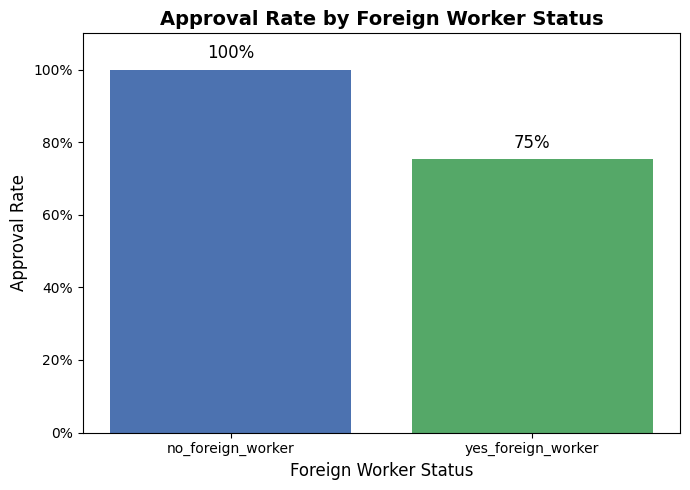

In [33]:
# Approval rate by foreign worker status
approval_by_foreign = (
    df_test.groupby("foreign_worker_readable")["approved_pred"]
    .mean()
    .reset_index()
    .rename(columns={"approved_pred": "approval_rate_pred"})
)

# Visualize in a Bar Chart
plt.figure(figsize=(7,5))
bars = plt.bar(
    approval_by_foreign["foreign_worker_readable"],
    approval_by_foreign["approval_rate_pred"],
    color=["#4C72B0", "#55A868"]
)

plt.title("Approval Rate by Foreign Worker Status", fontsize=14, fontweight="bold")
plt.ylabel("Approval Rate", fontsize=12)
plt.xlabel("Foreign Worker Status", fontsize=12)

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.02,
        f"{height:.0%}",
        ha='center',
        va='bottom',
        fontsize=12
    )

plt.ylim(0, 1.1)
plt.tight_layout()
plt.show()

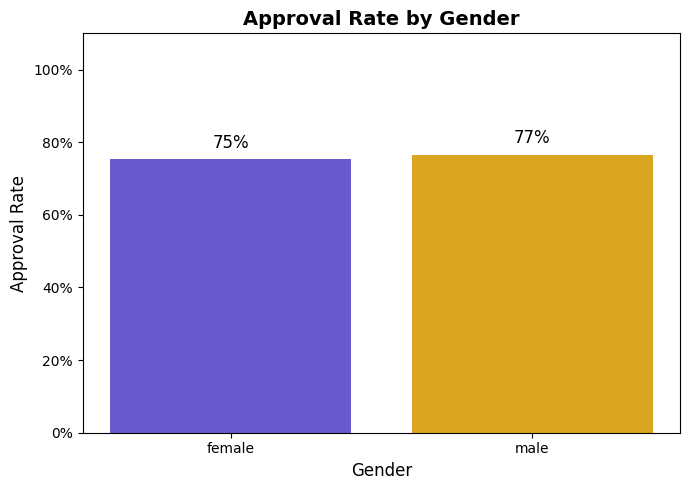

In [34]:
# Approval rate by gender
approval_by_gender = (
    df_test.groupby("gender")["approved_pred"]
    .mean()
    .reset_index()
    .rename(columns={"approved_pred": "approval_rate_pred"})
)

# Visualize in a Bar Chart
plt.figure(figsize=(7,5))
bars = plt.bar(
    approval_by_gender["gender"],
    approval_by_gender["approval_rate_pred"],
    color=["#6A5ACD", "#DAA520"]
)

plt.title("Approval Rate by Gender", fontsize=14, fontweight="bold")
plt.ylabel("Approval Rate", fontsize=12)
plt.xlabel("Gender", fontsize=12)

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.02,
        f"{height:.0%}",
        ha='center',
        va='bottom',
        fontsize=12
    )

plt.ylim(0, 1.1)
plt.tight_layout()
plt.show()

/tmp/ipython-input-1794385741.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_test.groupby("age_bucket")["approved_pred"]


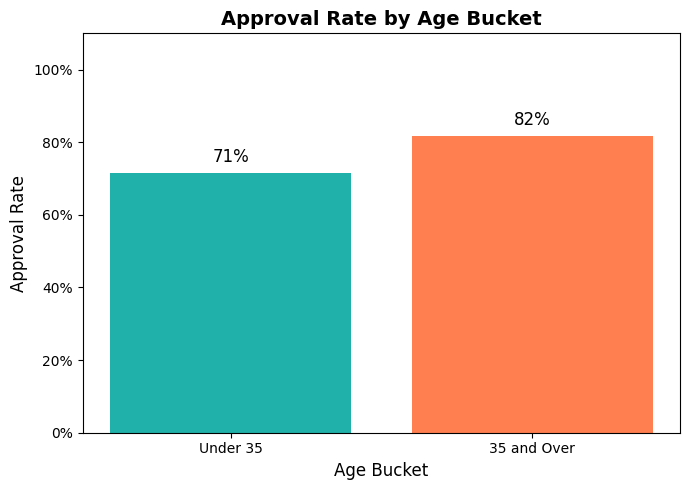

In [35]:
# Approval rate by age bucket
approval_by_age_bucket = (
    df_test.groupby("age_bucket")["approved_pred"]
    .mean()
    .reset_index()
    .rename(columns={"approved_pred": "approval_rate_pred"})
)

# Visualize in a Bar Chart
plt.figure(figsize=(7,5))
bars = plt.bar(
    approval_by_age_bucket["age_bucket"],
    approval_by_age_bucket["approval_rate_pred"],
    color=["#20B2AA", "#FF7F50"]
)

plt.title("Approval Rate by Age Bucket", fontsize=14, fontweight="bold")
plt.ylabel("Approval Rate", fontsize=12)
plt.xlabel("Age Bucket", fontsize=12)

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.02,
        f"{height:.0%}",
        ha='center',
        va='bottom',
        fontsize=12
    )

plt.ylim(0, 1.1)
plt.tight_layout()
plt.show()

## ⚖️ Confusion Matrices by Subgroup

Here I examine how the model performs for the different subgroups by looking at confusion matrices within each. This helps reveal whether certain groups experience higher false positive or false negative rates, which is central to a fairness audit.

In [36]:
from sklearn.metrics import confusion_matrix

print("Confusion Matrices by Foreign Worker Status:")
for group in df_test["foreign_worker_readable"].unique():
    group_df = df_test[df_test["foreign_worker_readable"] == group]
    cm = confusion_matrix(group_df["y_true"], group_df["y_pred"], labels=[1, 2])

    print(f"\nGroup: {group}")
    print("Labels: [1 = good/approved, 2 = bad/rejected]")
    print(cm)

Confusion Matrices by Foreign Worker Status:

Group: yes_foreign_worker
Labels: [1 = good/approved, 2 = bad/rejected]
[[290  46]
 [ 74  73]]

Group: no_foreign_worker
Labels: [1 = good/approved, 2 = bad/rejected]
[[14  0]
 [ 3  0]]


In [37]:
print("Confusion Matrices Gender:")
for group in df_test["gender"].unique():
    group_df = df_test[df_test["gender"] == group]
    cm = confusion_matrix(group_df["y_true"], group_df["y_pred"], labels=[1, 2])

    print(f"\nGroup: {group}")
    print("Labels: [1 = good/approved, 2 = bad/rejected]")
    print(cm)

Confusion Matrices Gender:

Group: male
Labels: [1 = good/approved, 2 = bad/rejected]
[[215  33]
 [ 44  46]]

Group: female
Labels: [1 = good/approved, 2 = bad/rejected]
[[89 13]
 [33 27]]


In [38]:
print("Confusion Matrices by Age Bucket:")
for group in df_test["age_bucket"].unique():
    group_df = df_test[df_test["age_bucket"] == group]
    cm = confusion_matrix(group_df["y_true"], group_df["y_pred"], labels=[1, 2])

    print(f"\nAge bucket: {group}")
    print("Labels: [1 = good/approved, 2 = bad/rejected]")
    print(cm)

Confusion Matrices by Age Bucket:

Age bucket: 35 and Over
Labels: [1 = good/approved, 2 = bad/rejected]
[[162  19]
 [ 29  24]]

Age bucket: Under 35
Labels: [1 = good/approved, 2 = bad/rejected]
[[142  27]
 [ 48  49]]


## 🧮 Manual Fairness Metrics

Before applying IBM AIF360, I compute several fairness metrics manually:
- Statistical Parity Difference: The difference of the predicted approval rates.
- True Positive Rate Gap: The difference in the rate of correctly approving good borrowers.
- False Positive Rate Gap: The difference in incorrectly approving bad borrowers.

These give an interpretable first view of potential inequities before diving further in.

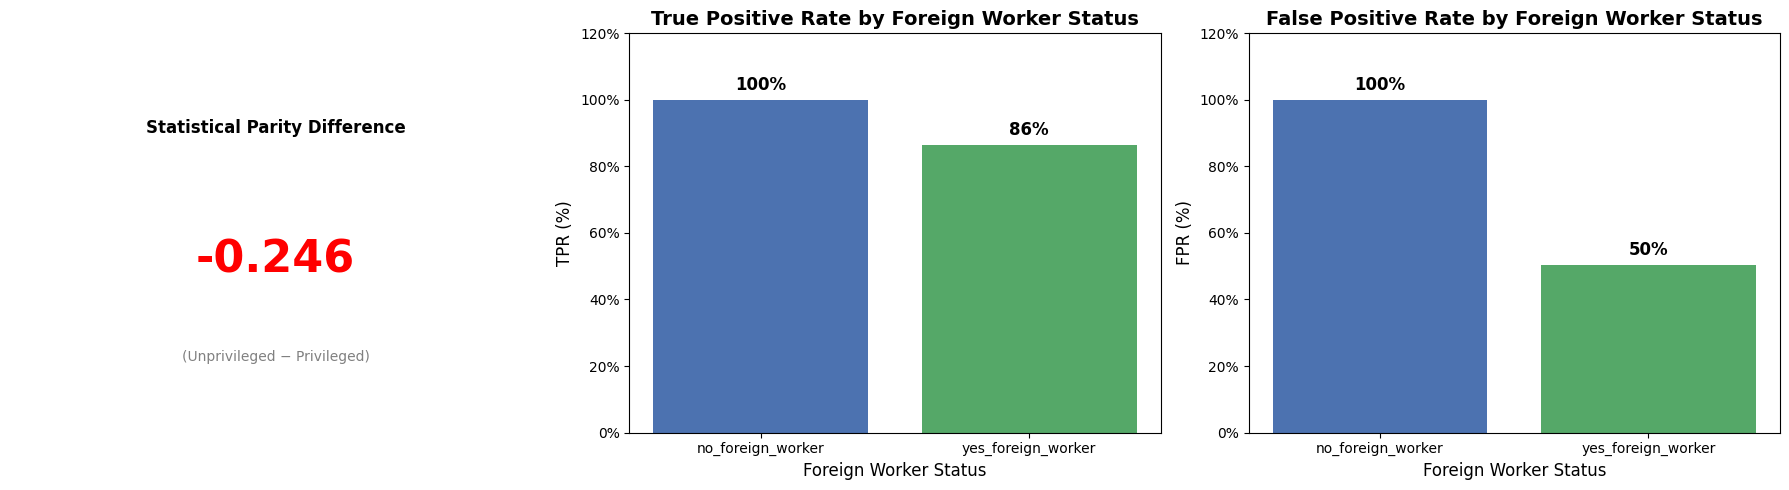

In [39]:

# Approval rate by foreign worker status
approval_by_foreign = (
    df_test.groupby("foreign_worker_readable")["approved_pred"]
    .mean()
    .reset_index()
    .rename(columns={"approved_pred": "approval_rate_pred"})
)

# Statistical Parity Difference (SPD)
approval_rates_fw = approval_by_foreign.set_index("foreign_worker_readable")["approval_rate_pred"]

priv = "no_foreign_worker"
unpriv = "yes_foreign_worker"

spd_fw = approval_rates_fw[unpriv] - approval_rates_fw[priv]

# True Positive Rates (TPR) for each group
tpr = {}
for group in df_test["foreign_worker_readable"].unique():
    group_df = df_test[df_test["foreign_worker_readable"] == group]
    positives = (group_df["y_true"] == 1).sum()
    if positives > 0:
        tpr[group] = (
            ((group_df["y_true"] == 1) & (group_df["y_pred"] == 1)).sum()
            / positives
        )
    else:
        tpr[group] = float("nan")

# False Positive Rates (FPR) fore each group
fpr = {}
for group in df_test["foreign_worker_readable"].unique():
    group_df = df_test[df_test["foreign_worker_readable"] == group]
    negatives = (group_df["y_true"] == 2).sum()
    if negatives > 0:
        fpr[group] = (
            ((group_df["y_true"] == 2) & (group_df["y_pred"] == 1)).sum()
            / negatives
        )
    else:
        fpr[group] = float("nan")

# Ensure consistent group order
groups = list(approval_by_foreign["foreign_worker_readable"])
tpr_values = [tpr[g] for g in groups]
fpr_values = [fpr[g] for g in groups]

# Colors
fw_colors = ["#4C72B0", "#55A868"]

# Axes
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# ---------- SPD KPI ----------
axes[0].axis("off")  # no axes for KPI tile

# Title
axes[0].text(
    0.5, 0.75,
    "Statistical Parity Difference",
    ha="center",
    fontsize=12,
    fontweight="bold",
    transform=axes[0].transAxes
)

# Big SPD number
axes[0].text(
    0.5, 0.4,
    f"{spd_fw:.3f}",
    ha="center",
    fontsize=32,
    fontweight="bold",
    color="#55A868" if spd_fw >= 0 else "red",
    transform=axes[0].transAxes
)

# Descriptor
axes[0].text(
    0.5, 0.18,
    "(Unprivileged − Privileged)",
    ha="center",
    fontsize=10,
    color="gray",
    transform=axes[0].transAxes
)

# ---------- TPR subplot ----------
axes[1].bar(groups, tpr_values, color=fw_colors)
axes[1].set_title("True Positive Rate by Foreign Worker Status", fontsize=14, fontweight="bold")
axes[1].set_ylabel("TPR (%)", fontsize=12)
axes[1].set_xlabel("Foreign Worker Status", fontsize=12)
axes[1].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

for idx, val in enumerate(tpr_values):
    if not (val != val):  # skip NaN
        axes[1].text(
            idx,
            val + 0.03,
            f"{val:.0%}",
            ha="center",
            fontsize=12,
            fontweight="bold"
        )

axes[1].set_ylim(0, 1.2)

# ---------- FPR subplot ----------
axes[2].bar(groups, fpr_values, color=fw_colors)
axes[2].set_title("False Positive Rate by Foreign Worker Status", fontsize=14, fontweight="bold")
axes[2].set_ylabel("FPR (%)", fontsize=12)
axes[2].set_xlabel("Foreign Worker Status", fontsize=12)
axes[2].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

for idx, val in enumerate(fpr_values):
    if not (val != val):  # skip NaN
        axes[2].text(
            idx,
            val + 0.03,
            f"{val:.0%}",
            ha="center",
            fontsize=12,
            fontweight="bold"
        )

axes[2].set_ylim(0, 1.2)

plt.tight_layout()
plt.show()

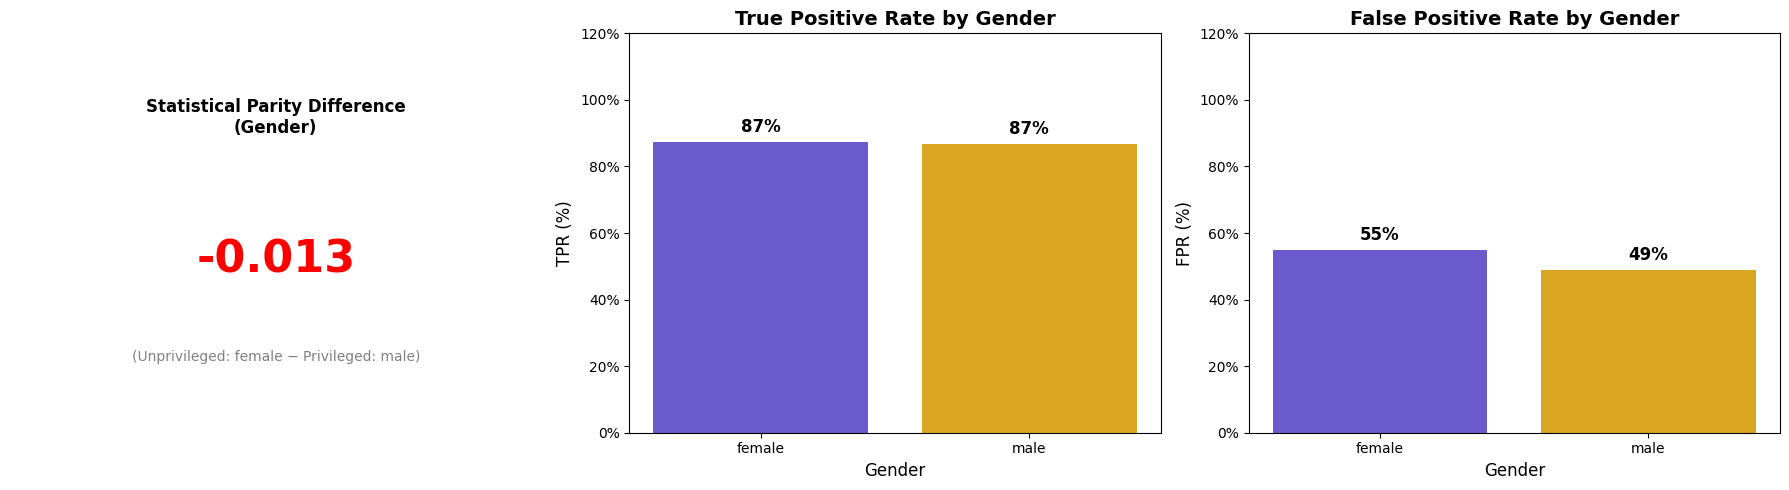

In [40]:
# Approval rate by gender
approval_by_gender = (
    df_test.groupby("gender")["approved_pred"]
    .mean()
    .reset_index()
    .rename(columns={"approved_pred": "approval_rate_pred"})
)

# Statistical Parity Difference (SPD) for gender
approval_rates_gender = approval_by_gender.set_index("gender")["approval_rate_pred"]

priv_gender = "male"
unpriv_gender = "female"

spd_gender = approval_rates_gender[unpriv_gender] - approval_rates_gender[priv_gender]

# True Positive Rates (TPR) for each group
tpr_gender = {}
for group in df_test["gender"].unique():
    group_df = df_test[df_test["gender"] == group]
    positives = (group_df["y_true"] == 1).sum()
    if positives > 0:
        tpr_gender[group] = (
            ((group_df["y_true"] == 1) & (group_df["y_pred"] == 1)).sum()
            / positives
        )
    else:
        tpr_gender[group] = float("nan")

# False Positive Rates (FPR) for each group
fpr_gender = {}
for group in df_test["gender"].unique():
    group_df = df_test[df_test["gender"] == group]
    negatives = (group_df["y_true"] == 2).sum()
    if negatives > 0:
        fpr_gender[group] = (
            ((group_df["y_true"] == 2) & (group_df["y_pred"] == 1)).sum()
            / negatives
        )
    else:
        fpr_gender[group] = float("nan")

# Ensure consistent group order
gender_groups = list(approval_by_gender["gender"])
tpr_gender_values = [tpr_gender[g] for g in gender_groups]
fpr_gender_values = [fpr_gender[g] for g in gender_groups]

# Colors
gender_colors = ["#6A5ACD", "#DAA520"]

# Axes
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# ---------- SPD KPI  ----------
axes[0].axis("off")

axes[0].text(
    0.5, 0.75,
    "Statistical Parity Difference\n(Gender)",
    ha="center",
    fontsize=12,
    fontweight="bold",
    transform=axes[0].transAxes
)

axes[0].text(
    0.5, 0.4,
    f"{spd_gender:.3f}",
    ha="center",
    fontsize=32,
    fontweight="bold",
    color="#55A868" if spd_gender >= 0 else "red",
    transform=axes[0].transAxes
)

axes[0].text(
    0.5, 0.18,
    "(Unprivileged: female − Privileged: male)",
    ha="center",
    fontsize=10,
    color="gray",
    transform=axes[0].transAxes
)

# ---------- TPR subplot ----------
axes[1].bar(gender_groups, tpr_gender_values, color=gender_colors)
axes[1].set_title("True Positive Rate by Gender", fontsize=14, fontweight="bold")
axes[1].set_ylabel("TPR (%)", fontsize=12)
axes[1].set_xlabel("Gender", fontsize=12)
axes[1].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

for idx, val in enumerate(tpr_gender_values):
    if not (val != val):  # skip NaN
        axes[1].text(
            idx,
            val + 0.03,
            f"{val:.0%}",
            ha="center",
            fontsize=12,
            fontweight="bold"
        )

axes[1].set_ylim(0, 1.2)

# ---------- FPR subplot ----------
axes[2].bar(gender_groups, fpr_gender_values, color=gender_colors)
axes[2].set_title("False Positive Rate by Gender", fontsize=14, fontweight="bold")
axes[2].set_ylabel("FPR (%)", fontsize=12)
axes[2].set_xlabel("Gender", fontsize=12)
axes[2].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

for idx, val in enumerate(fpr_gender_values):
    if not (val != val):  # skip NaN
        axes[2].text(
            idx,
            val + 0.03,
            f"{val:.0%}",
            ha="center",
            fontsize=12,
            fontweight="bold"
        )

axes[2].set_ylim(0, 1.2)

plt.tight_layout()
plt.show()

/tmp/ipython-input-3970958451.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_test.groupby("age_bucket")["approved_pred"]


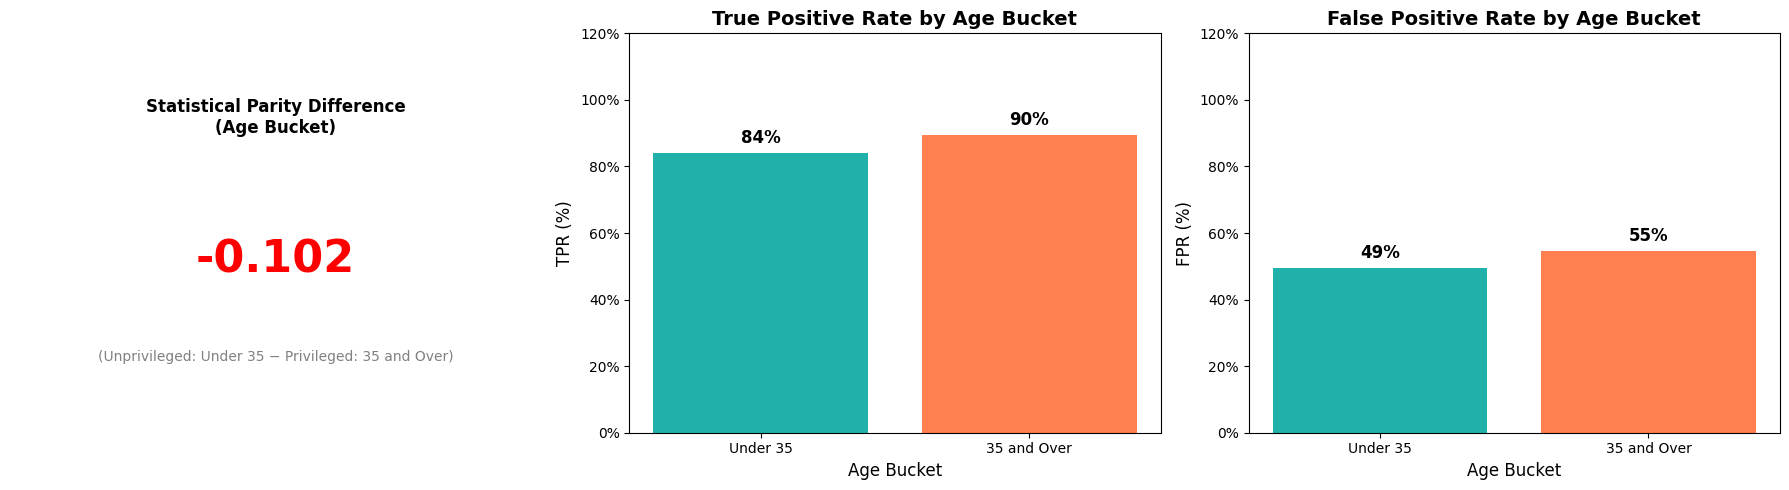

In [41]:
# Approval rate by age bucket
approval_by_age = (
    df_test.groupby("age_bucket")["approved_pred"]
    .mean()
    .reset_index()
    .rename(columns={"approved_pred": "approval_rate_pred"})
)

# Statistical Parity Difference (SPD) for age
approval_rates_age = approval_by_age.set_index("age_bucket")["approval_rate_pred"]

# Buckets
priv_age = "35 and Over"
unpriv_age = "Under 35"

spd_age = approval_rates_age[unpriv_age] - approval_rates_age[priv_age]

# True Positive Rates (TPR) for each group
tpr_age = {}
for group in df_test["age_bucket"].unique():
    group_df = df_test[df_test["age_bucket"] == group]
    positives = (group_df["y_true"] == 1).sum()
    if positives > 0:
        tpr_age[group] = (
            ((group_df["y_true"] == 1) & (group_df["y_pred"] == 1)).sum()
            / positives
        )
    else:
        tpr_age[group] = float("nan")

# False Positive Rates (FPR) for each group
fpr_age = {}
for group in df_test["age_bucket"].unique():
    group_df = df_test[df_test["age_bucket"] == group]
    negatives = (group_df["y_true"] == 2).sum()
    if negatives > 0:
        fpr_age[group] = (
            ((group_df["y_true"] == 2) & (group_df["y_pred"] == 1)).sum()
            / negatives
        )
    else:
        fpr_age[group] = float("nan")

# Ensure consistent group order
age_groups = list(approval_by_age["age_bucket"])
tpr_age_values = [tpr_age[g] for g in age_groups]
fpr_age_values = [fpr_age[g] for g in age_groups]

# Colors
age_colors = ["#20B2AA", "#FF7F50"]

# Axes
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# ---------- SPD KPI ----------
axes[0].axis("off")

axes[0].text(
    0.5, 0.75,
    "Statistical Parity Difference\n(Age Bucket)",
    ha="center",
    fontsize=12,
    fontweight="bold",
    transform=axes[0].transAxes
)

axes[0].text(
    0.5, 0.4,
    f"{spd_age:.3f}",
    ha="center",
    fontsize=32,
    fontweight="bold",
    color="#55A868" if spd_age >= 0 else "red",
    transform=axes[0].transAxes
)

axes[0].text(
    0.5, 0.18,
    f"(Unprivileged: {unpriv_age} − Privileged: {priv_age})",
    ha="center",
    fontsize=10,
    color="gray",
    transform=axes[0].transAxes
)

# ---------- TPR subplot ----------
axes[1].bar(age_groups, tpr_age_values, color=age_colors)
axes[1].set_title("True Positive Rate by Age Bucket", fontsize=14, fontweight="bold")
axes[1].set_ylabel("TPR (%)", fontsize=12)
axes[1].set_xlabel("Age Bucket", fontsize=12)
axes[1].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

for idx, val in enumerate(tpr_age_values):
    if not (val != val):  # skip NaN
        axes[1].text(
            idx,
            val + 0.03,
            f"{val:.0%}",
            ha="center",
            fontsize=12,
            fontweight="bold"
        )

axes[1].set_ylim(0, 1.2)

# ---------- FPR subplot ----------
axes[2].bar(age_groups, fpr_age_values, color=age_colors)
axes[2].set_title("False Positive Rate by Age Bucket", fontsize=14, fontweight="bold")
axes[2].set_ylabel("FPR (%)", fontsize=12)
axes[2].set_xlabel("Age Bucket", fontsize=12)
axes[2].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

for idx, val in enumerate(fpr_age_values):
    if not (val != val):  # skip NaN
        axes[2].text(
            idx,
            val + 0.03,
            f"{val:.0%}",
            ha="center",
            fontsize=12,
            fontweight="bold"
        )

axes[2].set_ylim(0, 1.2)

plt.tight_layout()
plt.show()

## 💻 Fairness Assessment with IBM AI Fairness 360 (AIF360)

In this section, I use IBM's open-source AI Fairness 360 toolkit to:

- Load our dataset into a BinaryLabelDataset
- Define privileged/unprivileged groups
- Compute fairness metrics like disparate impact and statistical parity
- Apply mitigation (e.g., Reweighing) and re-evaluate fairness

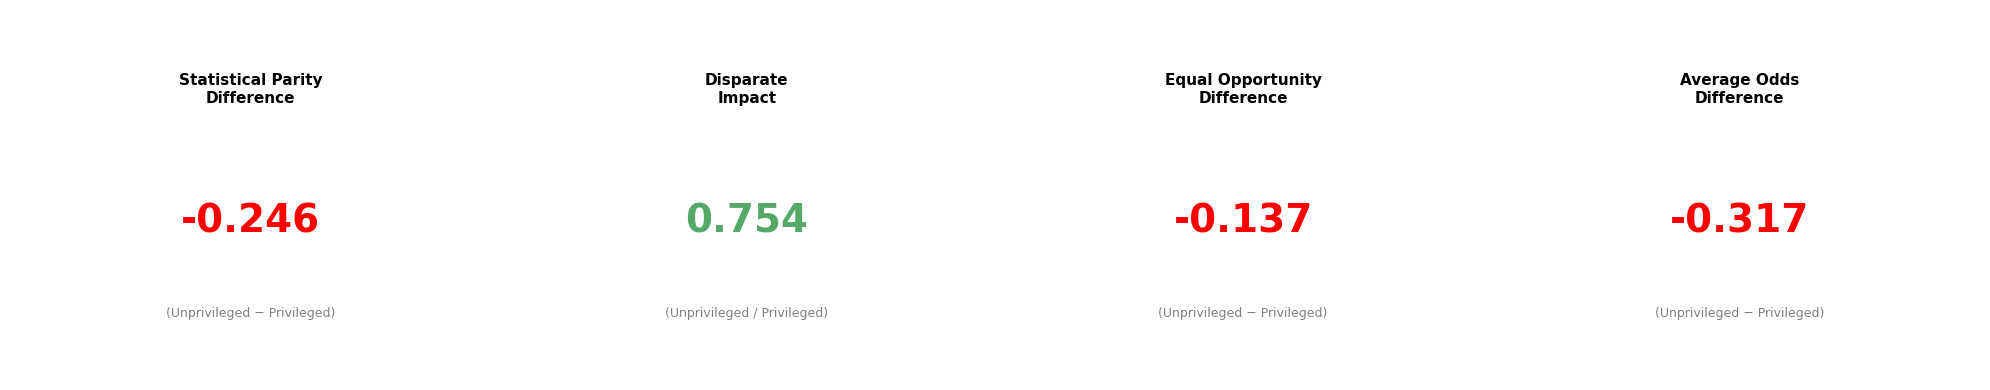

In [42]:
# -----------------------------------------
# Create foreign_worker_binary for AIF360
# -----------------------------------------
foreign_map_num = {
    "yes_foreign_worker": 1,
    "no_foreign_worker": 0
}

df_test["foreign_worker_binary"] = df_test["foreign_worker_readable"].map(foreign_map_num)

# -----------------------------
# Build AIF360 datasets for foreign worker status
# -----------------------------

# Ground the actuals dataset (uses y_true)
dataset_true_fw = BinaryLabelDataset(
    df=df_test[["y_true", "foreign_worker_binary"]].copy(),
    label_names=["y_true"],
    protected_attribute_names=["foreign_worker_binary"],
    favorable_label=1,
    unfavorable_label=2
)

# Ground the predicted dataset
dataset_pred_fw = dataset_true_fw.copy(deepcopy=True)
dataset_pred_fw.labels = df_test[["y_pred"]].values

# Define the privileged and unprivileged groups
unprivileged_groups_fw = [{"foreign_worker_binary": 1}]
privileged_groups_fw   = [{"foreign_worker_binary": 0}]

# -----------------------------
# Classification metrics for foreign worker status
# -----------------------------

metric_fw = ClassificationMetric(
    dataset_true_fw,
    dataset_pred_fw,
    unprivileged_groups=unprivileged_groups_fw,
    privileged_groups=privileged_groups_fw
)

spd_aif = metric_fw.statistical_parity_difference()
di_aif  = metric_fw.disparate_impact()
eod_aif = metric_fw.equal_opportunity_difference()
aod_aif = metric_fw.average_odds_difference()

# -----------------------------
# KPIs for foreign worker status
# -----------------------------

fig, axes = plt.subplots(1, 4, figsize=(20, 4))
metrics = {
    "Statistical Parity\nDifference": spd_aif,
    "Disparate\nImpact": di_aif,
    "Equal Opportunity\nDifference": eod_aif,
    "Average Odds\nDifference": aod_aif
}

# Choose colors for KPI tiles
def metric_color(val):
    # Green for "better", red for "worse"
    if val >= 0:
        return "#55A868"
    else:
        return "red"

for ax, (title, value) in zip(axes, metrics.items()):
    ax.axis("off")

    # Title
    ax.text(
        0.5, 0.75,
        title,
        ha="center",
        fontsize=11,
        fontweight="bold",
        transform=ax.transAxes
    )

    # Big metric value
    ax.text(
        0.5, 0.40,
        f"{value:.3f}",
        ha="center",
        fontsize=28,
        fontweight="bold",
        color=metric_color(value),
        transform=ax.transAxes
    )

    # Descriptor for DI (ratio)
    if title == "Disparate\nImpact":
        ax.text(
            0.5, 0.17,
            "(Unprivileged / Privileged)",
            ha="center",
            fontsize=9,
            color="gray",
            transform=ax.transAxes
        )
    else:
        ax.text(
            0.5, 0.17,
            "(Unprivileged − Privileged)",
            ha="center",
            fontsize=9,
            color="gray",
            transform=ax.transAxes
        )

plt.tight_layout()
plt.show()

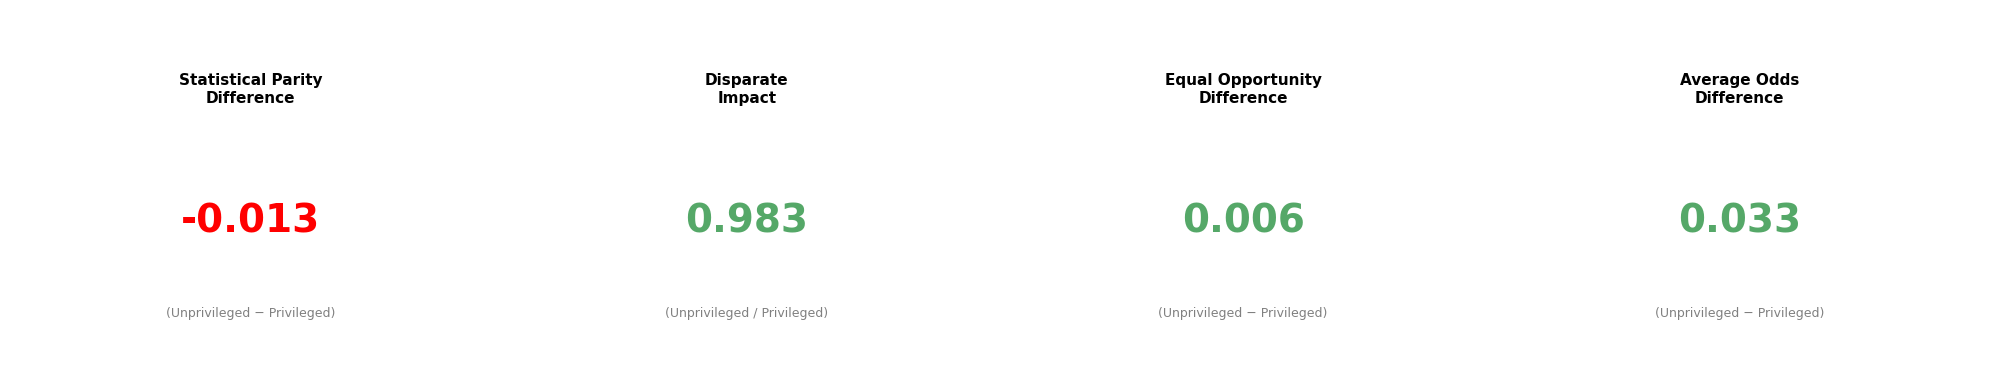

In [43]:
# -----------------------------------------
# Create gender_binary for AIF360
# -----------------------------------------
df_test["gender_binary"] = df_test["gender"].map({"male": 0, "female": 1})

# -----------------------------------------
# Build AIF360 datasets for gender
# -----------------------------------------

dataset_true_gender = BinaryLabelDataset(
    df=df_test[["y_true", "gender_binary"]].copy(),
    label_names=["y_true"],
    protected_attribute_names=["gender_binary"],
    favorable_label=1,
    unfavorable_label=2
)

dataset_pred_gender = dataset_true_gender.copy(deepcopy=True)
dataset_pred_gender.labels = df_test[["y_pred"]].values

# Define groups: female = unprivileged, male = privileged
unprivileged_groups_gender = [{"gender_binary": 1}]
privileged_groups_gender   = [{"gender_binary": 0}]

# -----------------------------------------
# Classification metrics for gender
# -----------------------------------------

metric_gender = ClassificationMetric(
    dataset_true_gender,
    dataset_pred_gender,
    unprivileged_groups=unprivileged_groups_gender,
    privileged_groups=privileged_groups_gender
)

spd_gender = metric_gender.statistical_parity_difference()
di_gender  = metric_gender.disparate_impact()
eod_gender = metric_gender.equal_opportunity_difference()
aod_gender = metric_gender.average_odds_difference()

# -----------------------------------------
# KPI Dashboard Visualization for gender
# -----------------------------------------

fig, axes = plt.subplots(1, 4, figsize=(20, 4))
metrics_gender = {
    "Statistical Parity\nDifference": spd_gender,
    "Disparate\nImpact": di_gender,
    "Equal Opportunity\nDifference": eod_gender,
    "Average Odds\nDifference": aod_gender
}

def metric_color(val):
    return "#55A868" if val >= 0 else "red"

for ax, (title, value) in zip(axes, metrics_gender.items()):
    ax.axis("off")

    # Title
    ax.text(
        0.5, 0.75, title,
        ha="center",
        fontsize=11,
        fontweight="bold",
        transform=ax.transAxes
    )

    # Big KPI value
    ax.text(
        0.5, 0.40, f"{value:.3f}",
        ha="center",
        fontsize=28,
        fontweight="bold",
        color=metric_color(value),
        transform=ax.transAxes
    )

    # Descriptor line
    if title == "Disparate\nImpact":
        desc = "(Unprivileged / Privileged)"
    else:
        desc = "(Unprivileged − Privileged)"

    ax.text(
        0.5, 0.17, desc,
        ha="center",
        fontsize=9,
        color="gray",
        transform=ax.transAxes
    )

plt.tight_layout()
plt.show()

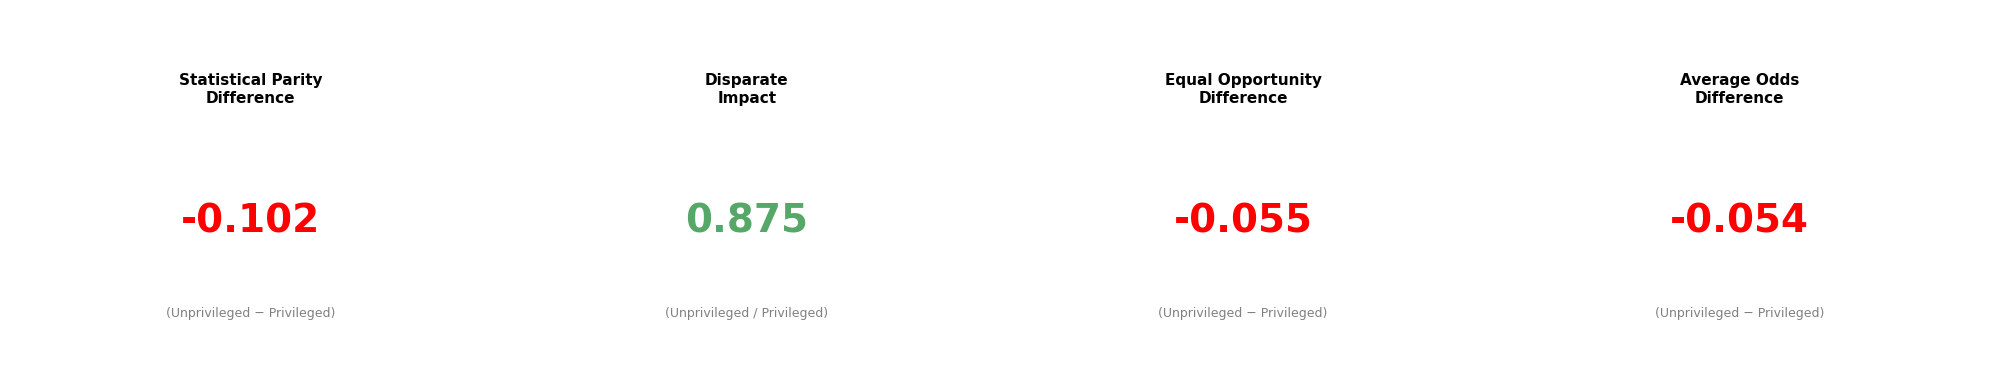

In [44]:
# -----------------------------------------
# Create age_bucket_binary for AIF360
# -----------------------------------------

# 35 and Over = privileged (0), Under 35 = unprivileged (1)
age_bucket_map_num = {
    "35 and Over": 0,
    "Under 35": 1
}
df_test["age_bucket_binary"] = df_test["age_bucket"].map(age_bucket_map_num)

# -----------------------------------------
# Build AIF360 datasets for age bucket
# -----------------------------------------

dataset_true_age = BinaryLabelDataset(
    df=df_test[["y_true", "age_bucket_binary"]].copy(),
    label_names=["y_true"],
    protected_attribute_names=["age_bucket_binary"],
    favorable_label=1,
    unfavorable_label=2
)

dataset_pred_age = dataset_true_age.copy(deepcopy=True)
dataset_pred_age.labels = df_test[["y_pred"]].values

# Privileged = 35 and Over (0), Unprivileged = Under 35 (1)
unprivileged_groups_age = [{"age_bucket_binary": 1}]
privileged_groups_age   = [{"age_bucket_binary": 0}]

# -----------------------------------------
# Classification metrics for age bucket
# -----------------------------------------

metric_age = ClassificationMetric(
    dataset_true_age,
    dataset_pred_age,
    unprivileged_groups=unprivileged_groups_age,
    privileged_groups=privileged_groups_age
)

spd_age = metric_age.statistical_parity_difference()
di_age  = metric_age.disparate_impact()
eod_age = metric_age.equal_opportunity_difference()
aod_age = metric_age.average_odds_difference()

# -----------------------------------------
# KPI Dashboard Visualization for age bucket
# -----------------------------------------

fig, axes = plt.subplots(1, 4, figsize=(20, 4))
metrics_age = {
    "Statistical Parity\nDifference": spd_age,
    "Disparate\nImpact": di_age,
    "Equal Opportunity\nDifference": eod_age,
    "Average Odds\nDifference": aod_age
}

def metric_color(val):
    return "#55A868" if val >= 0 else "red"

for ax, (title, value) in zip(axes, metrics_age.items()):
    ax.axis("off")

    # Title
    ax.text(
        0.5, 0.75, title,
        ha="center",
        fontsize=11,
        fontweight="bold",
        transform=ax.transAxes
    )

    # Big KPI value
    ax.text(
        0.5, 0.40, f"{value:.3f}",
        ha="center",
        fontsize=28,
        fontweight="bold",
        color=metric_color(value),
        transform=ax.transAxes
    )

    # Descriptor line
    if title == "Disparate\nImpact":
        desc = "(Unprivileged / Privileged)"
    else:
        desc = "(Unprivileged − Privileged)"

    ax.text(
        0.5, 0.17, desc,
        ha="center",
        fontsize=9,
        color="gray",
        transform=ax.transAxes
    )

plt.tight_layout()
plt.show()

In [46]:
'''

ONLY RUN WHEN NEED TO CONVERT TO HTML

# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

# Covert to HTML
!pip install nbconvert
!jupyter nbconvert --to html "/content/drive/MyDrive/Ethics in AI/notebooks/ai_lending_algorithmic_audit.ipynb"

'''

Mounted at /content/drive
[NbConvertApp] Converting notebook /content/drive/MyDrive/Ethics in AI/notebooks/ai_lending_algorithmic_audit.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 9 image(s).
[NbConvertApp] Writing 883111 bytes to /content/drive/MyDrive/Ethics in AI/notebooks/ai_lending_algorithmic_audit.html
